# Fe-C diffusion and elastodiffusivity
Taking data from R.G.A. Veiga, M. Perez, C. Becquart, E. Clouet and C. Domain, Acta mater. **59** (2011) p. 6963 [doi:10.1016/j.actamat.2011.07.048](http://dx.doi.org/10.1016/j.actamat.2011.07.048)

Fe in the body-centered cubic phase, $a_0 = 0.28553\text{ nm}$; C sit at octahedral sites, where the transition states between octahedral sites are represented by tetrahedral sites. The data is obtained from an EAM potential, where $C_{11} = 243\text{ GPa}$, $C_{12}=145\text{ GPa}$, and $C_{44} = 116\text{ GPa}$. The tetrahedral transition state is 0.816 eV above the octahedral site, and the attempt frequency is taken as 10 THz ($10^{13}\text{ Hz}$).

The dipole tensors can be separated into *parallel* and *perpendicular* components; the parallel direction points towards the closest Fe atoms for the C, while the perpendicular components lie in the interstitial plane. For the octahedral, the parallel component is 8.03 eV, and the perpendicular is 3.40 eV; for the tetrahedral transition state, the parallel component is 4.87 eV, and the perpendicular is 6.66 eV.

In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import onsager.crystal as crystal
import onsager.OnsagerCalc as onsager
from scipy.constants import physical_constants
kB = physical_constants['Boltzmann constant in eV/K'][0]

Create BCC lattice (lattice constant in nm).

In [2]:
a0 = 0.28553
Fe = crystal.Crystal.BCC(a0, "Fe")
print(Fe)

#Lattice:
  a1 = [-0.142765  0.142765  0.142765]
  a2 = [ 0.142765 -0.142765  0.142765]
  a3 = [ 0.142765  0.142765 -0.142765]
#Basis:
  (Fe) 0.0 = [ 0.  0.  0.]


Elastic constants converted from GPa ($10^9$ J/m$^3$) to eV/(atomic volume).

In [3]:
stressconv = 1e9*1e-27*Fe.volume/physical_constants['electron volt'][0]
c11, c12, c44 = 243*stressconv, 145*stressconv, 116*stressconv
s11, s12, s44 = (c11+c12)/((c11-c12)*(c11+2*c12)), -c12/((c11-c12)*(c11+2*c12)), 1/c44
print('S11 = {:.4f} S12 = {:.4f} S44 = {:.4f}'.format(s11, s12, s44))
stensor = np.zeros((3,3,3,3))
for a in range(3):
    for b in range(3):
        for c in range(3):
            for d in range(3):
                if a==b and b==c and c==d: stensor[a,b,c,d] = s11
                elif a==b and c==d: stensor[a,b,c,d] = s12
                elif (a==d and b==c) or (a==c and b==d): stensor[a,b,c,d] = s44/4

S11 = 0.1023 S12 = -0.0382 S44 = 0.1187


Add carbon interstitial sites at octahedral sites in the lattice. This code (1) gets the set of symmetric Wyckoff positions corresponding to the single site $[00\frac12]$ (first translated into unit cell coordinates), and then adds that new basis to our Fe crystal to generate a *new* crystal structure, that we name "FeC".

In [4]:
uoct = np.dot(Fe.invlatt, np.array([0, 0, 0.5*a0]))
FeC = Fe.addbasis(Fe.Wyckoffpos(uoct), ["C"])
print(FeC)

#Lattice:
  a1 = [-0.142765  0.142765  0.142765]
  a2 = [ 0.142765 -0.142765  0.142765]
  a3 = [ 0.142765  0.142765 -0.142765]
#Basis:
  (Fe) 0.0 = [ 0.  0.  0.]
  (C) 1.0 = [ 0.   0.5  0.5]
  (C) 1.1 = [ 0.5  0.5  0. ]
  (C) 1.2 = [ 0.5  0.   0.5]


Next, we construct a *diffuser* based on our interstitial. We need to create a `sitelist` (which will be the Wyckoff positions) and a `jumpnetwork` for the transitions between the sites. There are tags that correspond to the unique states and transitions in the diffuser. 

In [5]:
chem = 1  # 1 is the index corresponding to our C atom in the crystal
sitelist = FeC.sitelist(chem)
jumpnetwork = FeC.jumpnetwork(chem, 0.6*a0)  # 0.6*a0 is the cutoff distance for finding jumps
FeCdiffuser = onsager.Interstitial(FeC, chem, sitelist, jumpnetwork)
print(FeCdiffuser)

Diffuser for atom 1 (C)
#Lattice:
  a1 = [-0.142765  0.142765  0.142765]
  a2 = [ 0.142765 -0.142765  0.142765]
  a3 = [ 0.142765  0.142765 -0.142765]
#Basis:
  (Fe) 0.0 = [ 0.  0.  0.]
  (C) 1.0 = [ 0.   0.5  0.5]
  (C) 1.1 = [ 0.5  0.5  0. ]
  (C) 1.2 = [ 0.5  0.   0.5]
states:
i:+0.000,+0.500,+0.500
transitions:
i:+0.500,+0.500,+0.000^i:+0.500,+1.000,+0.500



Next, we assemble our data: the energies, prefactors, and dipoles for the C atom in Fe, matched to the *representative* states: these are the first states in the lists, which are also identified by the tags above.

*A note about units:* If $\nu_0$ is in THz, and $a_0$ is in nm, then $a_0^2\nu_0 = 10^{-2}\text{ cm}^2/\text{s}$. Thus, we multiply by `Dconv` = $10^{-2}$ so that our diffusivity is output in cm<sup>2</sup>/s.

In [6]:
Dconv = 1e-2
vu0 = 10*Dconv
Etrans = 0.816
dipoledict = {'Poctpara': 8.03, 'Poctperp': 3.40, 
              'Ptetpara': 4.87, 'Ptetperp': 6.66}
FeCthermodict = {'pre': np.ones(len(sitelist)), 'ene': np.zeros(len(sitelist)),
                 'preT': vu0*np.ones(len(jumpnetwork)), 
                 'eneT': Etrans*np.ones(len(jumpnetwork))}
# now to construct the site and transition dipole tensors; we use a "direction"--either
# the site position or the jump direction--to determine the parallel and perpendicular
# directions.
for dipname, Pname, direction in zip(('dipole', 'dipoleT'), ('Poct', 'Ptet'), 
                                     (np.dot(FeC.lattice, FeC.basis[chem][sitelist[0][0]]),
                                      jumpnetwork[0][0][1])):
    # identify the non-zero index in our direction:
    paraindex = [n for n in range(3) if not np.isclose(direction[n], 0)][0]
    Ppara, Pperp = dipoledict[Pname + 'para'], dipoledict[Pname + 'perp']
    FeCthermodict[dipname] = np.diag([Ppara if i==paraindex else Pperp 
                                      for i in range(3)])
for k,v in FeCthermodict.items():
    print('{}: {}'.format(k, v))

dipoleT: [[ 4.87  0.    0.  ]
 [ 0.    6.66  0.  ]
 [ 0.    0.    6.66]]
dipole: [[ 8.03  0.    0.  ]
 [ 0.    3.4   0.  ]
 [ 0.    0.    3.4 ]]
pre: [ 1.]
ene: [ 0.]
preT: [ 0.1]
eneT: [ 0.816]


We look at the diffusivity $D$, the elastodiffusivity $d$, and the activation volume tensor $V$ over a range of temperatures from 300K to 1200K.

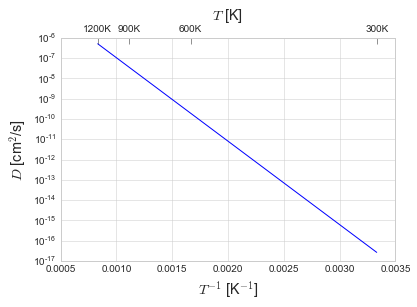

In [7]:
Trange = np.linspace(300, 1200, 91)
Tlabels = Trange[0::30]
Dlist = []
for T in Trange:
    beta = 1./(kB*T)
    D = FeCdiffuser.diffusivity(FeCthermodict['pre'], beta*FeCthermodict['ene'], 
                                FeCthermodict['preT'], beta*FeCthermodict['eneT'])
    Dlist.append(D[0,0])
fig, ax1 = plt.subplots()
ax1.plot(1./Trange, np.array(Dlist))
ax1.set_yscale('log')
ax1.set_ylabel('$D$ [cm$^2$/s]', fontsize='x-large')
ax1.set_xlabel('$T^{-1}$ [K$^{-1}$]', fontsize='x-large')
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks([1./t for t in Tlabels])
ax2.set_xticklabels(["{:.0f}K".format(t) for t in Tlabels])
ax2.set_xlabel('$T$ [K]', fontsize='x-large')
ax2.grid(False)
ax2.tick_params(axis='x', top='on', direction='in', length=6)
plt.show()
# plt.savefig('Fe-C-diffusivity.pdf', transparent=True, format='pdf')

Activation volume. We plot the isotropic value (change in diffusivity with respect to pressure), but also the $V_{xxxx}$, $V_{xxyy}$, and $V_{xyxy}$ terms. Interestingly, the $V_{xxxx}$ term is negative---which indicates that diffusivity along the $[100]$ direction *increases* with compressive stress in the $[100]$ direction.

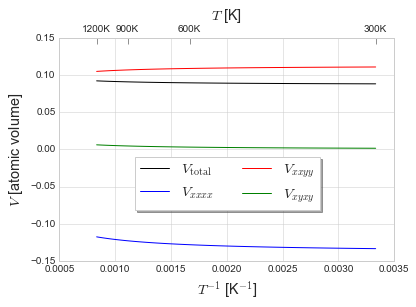

In [8]:
Trange = np.linspace(300, 1200, 91)
Tlabels = Trange[0::30]
Dlist = []
Vlist = []
for T in Trange:
    beta = 1./(kB*T)
    D, dD = FeCdiffuser.elastodiffusion(FeCthermodict['pre'], beta*FeCthermodict['ene'], 
                                        [beta*FeCthermodict['dipole']],
                                        FeCthermodict['preT'], beta*FeCthermodict['eneT'], 
                                        [beta*FeCthermodict['dipoleT']])
    Dlist.append(D[0,0])
    Vtensor = (kB*T/(D[0,0]))*np.tensordot(dD, stensor, axes=((2,3),(0,1)))
    Vlist.append([np.trace(np.trace(Vtensor))/3, 
                  Vtensor[0,0,0,0], Vtensor[0,0,1,1], Vtensor[0,1,0,1]])
V = np.array(Vlist)
fig, ax1 = plt.subplots()
ax1.plot(1./Trange, V[:,0], 'k', label='$V_{\\rm{total}}$')
ax1.plot(1./Trange, V[:,1], 'b', label='$V_{xxxx}$')
ax1.plot(1./Trange, V[:,2], 'r', label='$V_{xxyy}$')
ax1.plot(1./Trange, V[:,3], 'g', label='$V_{xyxy}$')
ax1.set_yscale('linear')
ax1.set_ylabel('$V$ [atomic volume]', fontsize='x-large')
ax1.set_xlabel('$T^{-1}$ [K$^{-1}$]', fontsize='x-large')
ax1.legend(bbox_to_anchor=(0.3,0.3,0.5,0.2), ncol=2, 
           shadow=True, frameon=True, fontsize='x-large')
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks([1./t for t in Tlabels])
ax2.set_xticklabels(["{:.0f}K".format(t) for t in Tlabels])
ax2.set_xlabel('$T$ [K]', fontsize='x-large')
ax2.grid(False)
ax2.tick_params(axis='x', top='on', direction='in', length=6)
plt.show()
# plt.savefig('Fe-C-activation-volume.pdf', transparent=True, format='pdf')

In [10]:
print('Total volume: {v[0]:.4f}, {V[0]:.4f}A^3\nV_xxxx: {v[1]:.4f}, {V[1]:.4f}A^3\nV_xxyy: {v[2]:.4f}, {V[2]:.4f}A^3\nV_xyxy: {v[3]:.4f}, {V[3]:.4f}A^3'.format(v=V[-1,:], V=V[-1,:]*1e3*Fe.volume))

Total volume: 0.0921, 1.0722A^3
V_xxxx: -0.1175, -1.3681A^3
V_xxyy: 0.1048, 1.2202A^3
V_xyxy: 0.0061, 0.0714A^3
